## Autoencoder

To begin our deep clustering of the NIS patients, we'll start off with an autoencoder. 

First, some definitions as part of this markdown cell:
- x : input features
- (e) : embedding layer
- (M) : dense-connected layer (MLP)
- E : encoder
- D : decoder
- (L) : loss layer
- L : loss function

The general workflow:
1. Identify exactly which features to take in.
2. Identify how to work with missing data wrt categorical labels, etc. (ie transform -128 to 0 as needed, etc)
3. Determine embedding sharing across multiple columns
4. Determine one-hot encoding process
5. Create encoder / decoder 
6. Create loss function (L2 norm + KL divergence)

#### More on Features

What continuous features do we have?
1. Age

What unique categorical features do we have?
1. Chronic Conditions
3. Biological sex
4. Mean household income for zipcode
2. Hospital Diagnoses, Not Chronic
3. Procedure codes (ICD9, SCCS, MCCS)
3. Admission information (month, weekend)
5. ED admission or not
6. Elective vs nonelective admission
7. Transfer in or not
7. Urban-rural classification scheme for hospital
8. NIS stratum for hospital

The above can be distilled into the following important major criteria:
1. Medical history (chronic conditions, sex, household income)
2. Admission events (diagnoses, injury, procedures)
3. Admission information (ED, elective, transfer)
4. Hospital information (urban-rural classification, nis-stratum)

Regardless, which of these categorical features need embeddings?
1. Diagnoses during hospital admission
2. Injuries during hospital admission
3. Procedures during hospital admission (PRn)
4. Chronic conditions (as represented by CHRONBn, CHRONn)

And for now, we'll one-hot-encode the following:
1. Biological sex
2. Elective admission
3. Transfer status
4. Zipcode income quartile
5. ED status

To kick things off on a good foundation, we'll use the ICD9 codes and not their derivative fields (eg CCS).

In [2]:
INPUT_FEATURES = {
    'AGE' : {'type': 'continuous', 'rep_func': None},
    'FEMALE' : {'type': 'one-hot', 'rep_func': None},
    'HCUP_ED' : {'type': 'one-hot', 'rep_func': None},
    'TRAN_IN' : {'type': 'one-hot', 'rep_func': None},
    'ELECTIVE' : {'type': 'one-hot', 'rep_func': None},
    'ZIPINC_QRTL' : {'type': 'one-hot', 'rep_func': None},
    'DXn' : {'type': 'embedding', 'rep_func': None},
    'ECODEn' : {'type': 'embedding', 'rep_func': None},
    'PRn' : {'type': 'embedding', 'rep_func': None},
}

In [3]:
%load_ext autoreload
%autoreload 2

In [90]:
import torch
import torch.nn as nn
import h5py
import numpy as np
import seaborn as sns

In [5]:
# device = torch.device('cuda:7')
device = torch.device('cpu')

In [6]:
import os
os.chdir('/home/aisinai/work/repos/nis_patient_encoding/')

In [7]:
from model.autoencoder.autoencoder import AutoEncoder
from data.data_loader import NISDatabase

In [8]:
DATA_FOLDER = 'data/raw/'

### Determine Embedding Information

#### Embedding layers

There should be 3 embedding layers:
1. Hospital Diagnoses
2. Pre-existing comorbidities (ICD9 codes)
3. Procedures
4. Injuries

Each embedding layer _i_ will take in a (_N_ x _Mi_) array of _N_ batch patients with _Mi_ features with vocabulary size _Ui_ that need to be embedded to dimension _Vi_. This amounts to (N x Mi) => (N x Vi). 

Then, the first encoding layer will accept a matrix of size (N x (sum(Vi) + Hj + C)), where Hi is the size of a one-hot encoded layer j and C is the number of continuous features present.

How many features to embed into? Some guesses:
1. Diagnoses => 256 (based on single-level CCS range)
2. Comorbidities => 256 (based on single-level CCS range)
2. Procedures => 256 (based on single-level CCS range)
3. Injury => 32 (based on single-level CCS range)

#### One interesting thought to consider => 
Sometimes, we may want to characterize patients not by organ system of disease, but by severity (eg CKD stage 1 and stage IV CHF aren't likely the same, but maybe CKD and CHF stage IV are)

### Explore Autoencoder Training

#### Create Embedding Information

In [8]:
db = NISDatabase(DATA_FOLDER + 'NIS_2012_2014_prototype.h5', 'TRAIN', {})

In [ ]:
def find_nlike_features(headers, emb_dict):
    """
    """

    for emb_name, emb in emb_dict.items():
        # idenitfy feature vector
        emb_dict[emb_name]['feature_idx'] = []
        len_name = len(emb['header_prefix'])

        for idx, header in enumerate(headers):
            if header[:len_name] == emb['header_prefix'] and header[len_name:len_name+1] != b'B':
                emb_dict[emb_name]['feature_idx'].append(idx)

In [ ]:
EMBEDDING_DICTIONARY = {
    'diagnoses' : {
        'header_prefix' : b'DX',
        'vocab_size' : 300000,
        'dimensions' : 256,
    },

    'procedures' : {
        'header_prefix' : b'PR',
        'vocab_size' : 100000,
        'dimensions' : 64,
    },

    'injury' : {
        'header_prefix' : b'ECODE',
        'vocab_size' : 100000,
        'dimensions' : 32,
    },

    'chronic_conditions' : {
        'header_prefix' : b'CHRONB',
        'vocab_size' : 19,
        'dimensions' : 16,
    }
}

In [ ]:
find_nlike_features(db.headers, EMBEDDING_DICTIONARY)

In [ ]:
DEFAULT_BUILD = {

    'encoding' : {
        'total_layers' : 3,
        'dimensions' : 64,
        'activation' : 'leaky_relu',
    },

    'latent' : {'dimensions' : 32},

    'decoding' : {
        'dimensions' : 64,
        'activation' : 'leaky_relu',
        'total_layers' : 3,
        'output_dims' : None
    }
}

In [ ]:
ONE_HOTS = {}
for idx, header in enumerate(db.headers):
    still_good = True
    if idx == 0:
        still_good = False
        
    if header[:5] == b'CHRON':
        still_good = False

    for embed_vec in EMBEDDING_DICTIONARY.values():
        if idx in embed_vec['features']:
            still_good = False
            break

    if still_good:
        ONE_HOTS[header.decode('utf-8')] = {}
        ONE_HOTS[header.decode('utf-8')]['idx'] = idx

In [ ]:
ONE_HOTS['ELECTIVE']['unique_vals'] = 2 # 0,1
ONE_HOTS['FEMALE']['unique_vals'] = 2 # 0,1
ONE_HOTS['TRAN_IN']['unique_vals'] = 3 # 0-2
ONE_HOTS['HCUP_ED']['unique_vals'] = 5 # 0-4
ONE_HOTS['ZIPINC_QRTL']['unique_vals'] = 5 # 1-4

In [ ]:
CONTINUOUS = {'age' : 0 }

In [ ]:
FEATURE_REPRESENTATIONS = {}
FEATURE_REPRESENTATIONS['embedding'] = EMBEDDING_DICTIONARY
FEATURE_REPRESENTATIONS['one_hots'] = ONE_HOTS
FEATURE_REPRESENTATIONS['continuous'] = CONTINUOUS

DEFAULT_BUILD['features'] = FEATURE_REPRESENTATIONS
DEFAULT_BUILD['decoding']['output_dims'] = db.headers.shape[0]

#### Create Autoencoder

In [ ]:
ae = AutoEncoder(DEFAULT_BUILD).to(device)

#### Spawn Data Loader and Others

In [ ]:
db_dl = torch.utils.data.DataLoader(db, batch_size=128, pin_memory=True, num_workers=4)

In [ ]:
from model.autoencoder.loss import loss_mse
loss = loss_mse
optimizer = torch.optim.Adam(ae.parameters(), lr=5e-4)

In [ ]:
from trainer.trainer import Trainer
train = Trainer(ae, loss, optimizer, db_dl, device)

In [ ]:
# train.train(1000, '/home/aisinai/work/repos/nis_patient_encoding/experiments/train_ae_001/')

#### Analyze outputs

In [ ]:
last_save = '/home/aisinai/work/repos/nis_patient_encoding/experiments/train_ae_001/1585653337.pth'
ae.load_state(last_save, device=device, prediction=True)

In [ ]:
samp_batch = next(iter(db_dl)).to(device)

In [ ]:
ae(samp_batch)

In [ ]:
samp_batch[-3]

In [ ]:
ae(samp_batch[-3:-2, :])

In [ ]:
ae(samp_batch[-3:-2, :]) - samp_batch[-3]

### Discussion with Eric

X) Go over architecture using train_ae_xxx.py as template

A) Loss function and output options:
1. Output tries to recreate input features => MSE over continuous, NLL over categorical, ? for embedded-cats
2. Output tries to recreate embedding + cont/cat features => MSE over continuous + embedded, NLL over categorical
3. Output tries to recreate input features, with embedding via 'de-embedding' from learned embedded weights (though E is noninvertible) => MSE over continuous, NLL over categorical, embedded-cats

B) Utility of a U-Net type of architecture in reconstruction?

NOTES:
1. Binary cross-entropy loss with sigmoid activation
1. Adversarial-esque W2V (with age buckets instead of continuous representation)
2. Predict a task OR MULTIPLE jointly (e.g. outcomes), not reconstruct => wide/deep

## Autoencoder 2.0

The modifications we'll make here are the following:
1. Loss will be calculated using MSE with the GT as the embedding + categorical cols + continuous cols.
2. Embedding dims needs to be decreased, since it's already >9000 features. Let's scale down by 1/2.
4. Returning now a second outuput from forward func to represent embedding + cat cols + cont col.
3. Modifying funcs and subfuncs to calculate output dims for this second output.
5. Renamed self.encoding_output_dims to self.dense_encoding_input_dims.

In [100]:
db = NISDatabase(DATA_FOLDER + 'NIS_2012_2014_proto_emb.h5', 'VAL', {})

In [101]:
from utils.experiments import find_nlike_features

In [102]:
EMBEDDING_DICTIONARY = {
    'DXn' : {
        'header_prefix' : b'DX',
        'num_classes' : 12583,
        'dimensions' : 256,
    },

    'PRn' : {
        'header_prefix' : b'PR',
        'num_classes' : 4445,
        'dimensions' : 64,
    },

    'ECODEn' : {
        'header_prefix' : b'ECODE',
        'num_classes' : 4445,
        'dimensions' : 32,
    },

    'CHRONBn' : {
        'header_prefix' : b'CHRONB',
        'num_classes' : 19,
        'dimensions' : 16,
    }
}

In [103]:
find_nlike_features(db.headers, EMBEDDING_DICTIONARY)

In [104]:
DEFAULT_BUILD = {

    'encoding' : {
        'total_layers' : 3,
        'dimensions' : 128,
        'activation' : 'leaky_relu',
    },

    'latent' : {'dimensions' : 32},

    'decoding' : {
        'dimensions' : 128,
        'activation' : 'leaky_relu',
        'total_layers' : 3,
        'output_dims' : None
    }
}

In [105]:
ONE_HOTS = {}
for idx, header in enumerate(db.headers):
    still_good = True
    if idx == 0:
        still_good = False
        
    if header[:5] == b'CHRON':
        still_good = False

    for embed_vec in EMBEDDING_DICTIONARY.values():
        if idx in embed_vec['feature_idx']:
            still_good = False
            break

    if still_good:
        ONE_HOTS[header.decode('utf-8')] = {}
        ONE_HOTS[header.decode('utf-8')]['feature_idx'] = idx

In [106]:
ONE_HOTS['ELECTIVE']['num_classes'] = 2 # 0,1
ONE_HOTS['FEMALE']['num_classes'] = 2 # 0,1
ONE_HOTS['TRAN_IN']['num_classes'] = 3 # 0-2
ONE_HOTS['HCUP_ED']['num_classes'] = 5 # 0-4
ONE_HOTS['ZIPINC_QRTL']['num_classes'] = 5 # 1-4

In [107]:
CONTINUOUS = {'AGE' : {'feature_idx': 0} }

In [108]:
FEATURE_REPRESENTATIONS = {}
FEATURE_REPRESENTATIONS['embedding'] = EMBEDDING_DICTIONARY
FEATURE_REPRESENTATIONS['one_hots'] = ONE_HOTS
FEATURE_REPRESENTATIONS['continuous'] = CONTINUOUS

DEFAULT_BUILD['features'] = FEATURE_REPRESENTATIONS

output_dims = np.sum([embedding['num_classes'] * len(embedding['feature_idx']) for embedding in DEFAULT_BUILD['features']['embedding'].values()])
output_dims += np.sum([catfeat['num_classes'] for catfeat in DEFAULT_BUILD['features']['one_hots'].values()])
output_dims += np.sum([1 for contfeat in DEFAULT_BUILD['features']['continuous'].values()])
DEFAULT_BUILD['decoding']['output_dims'] = output_dims

In [109]:
ae = AutoEncoder(DEFAULT_BUILD).to(device)

In [110]:
ae

AutoEncoder(
  (embeddings): ModuleDict(
    (DXn): Embedding(12583, 256)
    (PRn): Embedding(4445, 64)
    (ECODEn): Embedding(4445, 32)
    (CHRONBn): Embedding(19, 16)
  )
  (encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=9266, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LeakyReLU(

In [22]:
from model.autoencoder.loss import CustomLoss
loss = CustomLoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=5e-4)

In [57]:
db_dl = torch.utils.data.DataLoader(db, batch_size=128, pin_memory=True, num_workers=4)
samp_batch = next(iter(db_dl))

In [111]:
ae.load_state('/home/aisinai/work/repos/nis_patient_encoding/experiments/train_ae_002/1585911282.pth', prediction=True)

In [129]:
recon, target = ae.predict(samp_batch)

In [139]:
torch.sum(recon['DXn'].round_(), axis=1)

tensor([4., 2., 1., 2., 2., 1., 1., 1., 5., 5., 2., 2., 1., 2., 1., 1., 2., 2.,
        3., 2., 1., 1., 3., 1., 1., 2., 1., 1., 1., 3., 2., 2., 2., 3., 1., 1.,
        1., 1., 2., 5., 1., 1., 1., 2., 1., 2., 1., 2., 2., 2., 2., 2., 2., 2.,
        1., 3., 1., 1., 1., 1., 6., 2., 1., 2., 2., 1., 2., 5., 3., 1., 1., 1.,
        2., 1., 8., 2., 1., 1., 1., 3., 1., 2., 1., 7., 1., 1., 1., 2., 1., 1.,
        3., 1., 2., 1., 3., 3., 2., 1., 1., 2., 1., 2., 2., 1., 1., 2., 4., 2.,
        2., 2., 1., 1., 1., 2., 1., 2., 4., 3., 1., 1., 3., 2., 2., 2., 1., 1.,
        1., 4.], grad_fn=<SumBackward1>)

In [140]:
torch.sum(torch.abs(recon['DXn'].round_() - target['DXn']), axis=1)

tensor([15.,  8.,  4., 14.,  7.,  5., 18.,  5., 20., 22.,  6.,  1., 18.,  3.,
        12.,  5., 15.,  9., 16.,  5.,  5., 13., 14.,  6., 14., 16.,  2., 18.,
        10.,  3., 10.,  2.,  7., 14., 10.,  5.,  9.,  6.,  8., 19.,  8.,  1.,
         6.,  9.,  8.,  1.,  3., 22.,  9.,  1., 14.,  4.,  6., 18.,  8., 18.,
         6., 13., 10.,  4., 18., 11., 12., 10., 14.,  9., 12., 18., 16.,  7.,
         5.,  5., 26., 24., 16.,  6.,  9.,  3.,  6., 14., 11.,  2.,  3., 24.,
        10.,  5.,  4., 16.,  6.,  3., 21., 15., 11.,  5., 11., 26., 15., 15.,
         8.,  6.,  7., 18., 12.,  5., 13., 11., 18., 11., 26.,  9., 10., 16.,
         7.,  9.,  6.,  2., 10.,  4., 10., 14., 25.,  7., 10.,  7.,  4., 15.,
        10., 11.], grad_fn=<SumBackward1>)

In [93]:
params = 0
for param in ae.parameters():
    ps = param.shape
    if len(param.shape) > 1:
        ps_val = 1
        for p in ps:
            ps_val *= p
        params += ps_val
    else:
        params += ps[0]

In [33]:
loss(recon, target)

tensor(0.0974, grad_fn=<AddBackward0>)

In [ ]:
train = Trainer(ae, loss, optimizer, db_dl, device)

In [ ]:
train.train(1, '/home/aisinai/work/repos/nis_patient_encoding/experiments/testing/')

### Autoencoder 3.0

Improvements: 
1. added batch_norm and dropout layers
2. streamlined AE structure (using nn.Sequential autoencoder)
3. added learning rate scheduler.

Data Loading:

In [10]:
db = NISDatabase(DATA_FOLDER + 'NIS_2012_2014_proto_emb_red.h5', 'TRAIN', {})

In [11]:
from utils.experiments import *
from utils.feature_utils import calc_output_dims

In [12]:
EMBEDDING_DICTIONARY = {
    'DXn' : {
        'header_prefix' : b'DX',
        'num_classes' : 6202,
        'dimensions' : 256,
    },

    'PRn' : {
        'header_prefix' : b'PR',
        'num_classes' : 3722,
        'dimensions' : 64,
    },

    'ECODEn' : {
        'header_prefix' : b'ECODE',
        'num_classes' : 182,
        'dimensions' : 32,
    },

    'CHRONBn' : {
        'header_prefix' : b'CHRONB',
        'num_classes' : 19,
        'dimensions' : 16,
    }
}

In [13]:
DEFAULT_BUILD = {

    'encoding' : {
        'total_layers' : 3,
        'dimensions' : 256,
        'activation' : 'leaky_relu',
    },

    'latent' : {'dimensions' : 32},

    'decoding' : {
        'dimensions' : 256,
        'activation' : 'leaky_relu',
        'total_layers' : 3,
        'output_dims' : None
    }
}

In [15]:
ONE_HOT_LIST = [b'ELECTIVE', b'FEMALE', b'HCUP_ED', b'TRAN_IN', b'ZIPINC_QRTL', b'AGE']
ONE_HOTS = { feature.decode('utf-8') : {} for feature in ONE_HOT_LIST }

ONE_HOTS['ELECTIVE']['num_classes'] = 2 # 0,1
ONE_HOTS['FEMALE']['num_classes'] = 2 # 0,1
ONE_HOTS['TRAN_IN']['num_classes'] = 3 # 0-2
ONE_HOTS['HCUP_ED']['num_classes'] = 5 # 0-4
ONE_HOTS['ZIPINC_QRTL']['num_classes'] = 5 # 1-4
ONE_HOTS['AGE']['num_classes'] = 13 # 0-12 (must be allowed to guess in between as well)

In [16]:
CONTINUOUS = {}

In [17]:
FEATURE_REPRESENTATIONS = {}
FEATURE_REPRESENTATIONS['embedding'] = EMBEDDING_DICTIONARY
FEATURE_REPRESENTATIONS['one_hots'] = ONE_HOTS
FEATURE_REPRESENTATIONS['continuous'] = CONTINUOUS

DEFAULT_BUILD['features'] = FEATURE_REPRESENTATIONS

find_nlike_features(db.headers, FEATURE_REPRESENTATIONS['embedding'])
FEATURE_REPRESENTATIONS['one_hots'] = create_onehot_info(db, FEATURE_REPRESENTATIONS['one_hots'], FEATURE_REPRESENTATIONS['embedding'])
DEFAULT_BUILD['features'] = FEATURE_REPRESENTATIONS
calc_output_dims(DEFAULT_BUILD)

Autoencoder Creation:

In [61]:
from model.autoencoder.loss import CustomLoss
from trainer.trainer import Trainer

loss = CustomLoss()

In [53]:
ae = AutoEncoder(DEFAULT_BUILD).to(device)
ae.load_state('/home/aisinai/work/repos/nis_patient_encoding/experiments/train_ae_008/1586169923.pth')

In [54]:
db_dl = torch.utils.data.DataLoader(db, batch_size=1028, pin_memory=True, num_workers=4)
samp_batch = next(iter(db_dl))

In [56]:
trainer = Trainer(ae, loss, 5e-4, db_dl, device)

In [57]:
recons, targets = ae.predict(samp_batch)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1358: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [104]:
trainer.accuracy = {}
trainer.get_accuracy(recons, targets)

for feature, accuracy in trainer.accuracy.items():
    print("Feature: {0} :: Accuracy: {1:.02f}%".format(feature, accuracy * 100))


Feature: DXn :: Accuracy: 70.34%
Feature: PRn :: Accuracy: 88.81%
Feature: ECODEn :: Accuracy: 99.95%
Feature: CHRONBn :: Accuracy: 100.00%
Feature: ELECTIVE :: Accuracy: 100.00%
Feature: FEMALE :: Accuracy: 100.00%
Feature: HCUP_ED :: Accuracy: 100.00%
Feature: TRAN_IN :: Accuracy: 100.00%
Feature: ZIPINC_QRTL :: Accuracy: 100.00%
Feature: AGE :: Accuracy: 99.67%


#### Latent Space Exploration

In [71]:
latent_space = ae.latent_representation(samp_batch).detach()

In [74]:
from sklearn.manifold import TSNE
latent_space_embedded = TSNE(n_components=2)

In [75]:
latent_space_embedded.fit(latent_space)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, n_jobs=None,
     perplexity=30.0, random_state=None, verbose=0)

In [76]:
latent_space_embedded.embedding_

array([[-17.100409  ,  32.538326  ],
       [ -0.10317767,   3.9123917 ],
       [-21.39461   , -13.734325  ],
       ...,
       [ -3.0478516 ,  31.598774  ],
       [-11.695884  , -22.259556  ],
       [ 25.28815   , -18.134932  ]], dtype=float32)

[Text(0.5, 1.0, 'TSNE')]

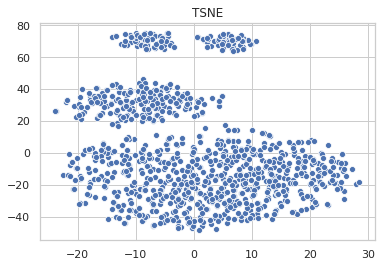

In [93]:
sns.set(style="whitegrid")
sns.scatterplot(*latent_space_embedded.embedding_.T).set(title='TSNE')

In [85]:
from sklearn.decomposition import PCA
latent_space_pca = PCA(n_components=2)

In [86]:
latent_space_pca.fit(latent_space)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

[Text(0.5, 1.0, 'PCA')]

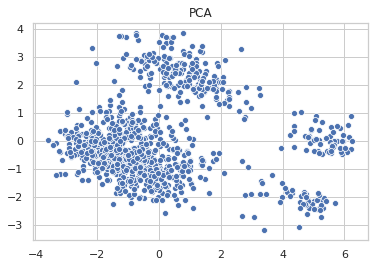

In [94]:
sns.set(style="whitegrid")
sns.scatterplot(*latent_space_pca.transform(latent_space).T).set(title='PCA')

### Autoencoder 4.0

Improvements: 
1. conical architecture

Data Loading:

In [241]:
db = NISDatabase(DATA_FOLDER + 'NIS_2012_2014_proto_emb_red.h5', 'TRAIN', {})

In [11]:
from utils.experiments import *
from utils.feature_utils import calc_output_dims

In [12]:
EMBEDDING_DICTIONARY = {
    'DXn' : {
        'header_prefix' : b'DX',
        'num_classes' : 6202,
        'dimensions' : 256,
    },

    'PRn' : {
        'header_prefix' : b'PR',
        'num_classes' : 3722,
        'dimensions' : 64,
    },

    'ECODEn' : {
        'header_prefix' : b'ECODE',
        'num_classes' : 182,
        'dimensions' : 32,
    },

    'CHRONBn' : {
        'header_prefix' : b'CHRONB',
        'num_classes' : 19,
        'dimensions' : 16,
    }
}

In [117]:
DEFAULT_BUILD = {
    'encoding' : {
        'total_layers' : 3,
        'scale' : 2,
        'activation' : 'leaky_relu',
    },

    'latent' : {'dimensions' : 32},

    'decoding' : {
        'scale' : 2,
        'activation' : 'leaky_relu',
        'total_layers' : 3,
        'output_dims' : None
    }
}


In [118]:
ONE_HOT_LIST = [b'ELECTIVE', b'FEMALE', b'HCUP_ED', b'TRAN_IN', b'ZIPINC_QRTL', b'AGE']
ONE_HOTS = { feature.decode('utf-8') : {} for feature in ONE_HOT_LIST }

ONE_HOTS['ELECTIVE']['num_classes'] = 2 # 0,1
ONE_HOTS['FEMALE']['num_classes'] = 2 # 0,1
ONE_HOTS['TRAN_IN']['num_classes'] = 3 # 0-2
ONE_HOTS['HCUP_ED']['num_classes'] = 5 # 0-4
ONE_HOTS['ZIPINC_QRTL']['num_classes'] = 5 # 1-4
ONE_HOTS['AGE']['num_classes'] = 13 # 0-12 (must be allowed to guess in between as well)

In [119]:
CONTINUOUS = {}

In [120]:
FEATURE_REPRESENTATIONS = {}
FEATURE_REPRESENTATIONS['embedding'] = EMBEDDING_DICTIONARY
FEATURE_REPRESENTATIONS['one_hots'] = ONE_HOTS
FEATURE_REPRESENTATIONS['continuous'] = CONTINUOUS

DEFAULT_BUILD['features'] = FEATURE_REPRESENTATIONS

find_nlike_features(db.headers, FEATURE_REPRESENTATIONS['embedding'])
FEATURE_REPRESENTATIONS['one_hots'] = create_onehot_info(db, FEATURE_REPRESENTATIONS['one_hots'], FEATURE_REPRESENTATIONS['embedding'])
DEFAULT_BUILD['features'] = FEATURE_REPRESENTATIONS
calc_output_dims(DEFAULT_BUILD)

Autoencoder Creation:

In [124]:
ae = AutoEncoder(DEFAULT_BUILD).to(device)
# ae.load_state('/home/aisinai/work/repos/nis_patient_encoding/experiments/train_ae_008/1586169923.pth')

In [125]:
ae

AutoEncoder(
  (model): ModuleDict(
    (embeddings): ModuleDict(
      (DXn): Embedding(6202, 256)
      (PRn): Embedding(3722, 64)
      (ECODEn): Embedding(182, 32)
      (CHRONBn): Embedding(19, 16)
    )
    (autoencoder): Sequential(
      (encoder): Sequential(
        (0): Sequential(
          (0): Linear(in_features=9278, out_features=256, bias=True)
          (1): LeakyReLU(negative_slope=0.01, inplace=True)
          (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Dropout(p=0.0, inplace=False)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=128, bias=True)
          (1): LeakyReLU(negative_slope=0.01, inplace=True)
          (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Dropout(p=0.0, inplace=False)
        )
        (2): Sequential(
          (0): Linear(in_features=128, out_features=64, bias=True)
          (1): LeakyReLU(negat

In [54]:
db_dl = torch.utils.data.DataLoader(db, batch_size=512, pin_memory=True, num_workers=4)
samp_batch = next(iter(db_dl))

In [57]:
recons, targets = ae.predict(samp_batch)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1358: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [61]:
from model.autoencoder.loss import CustomLoss
from trainer.trainer import Trainer

loss = CustomLoss()

In [56]:
trainer = Trainer(ae, loss, 5e-4, db_dl, device)